In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## 1. Data Loading and Cleaning

Data Cleaing was completed on MySQL Workbench. Please refer to **READ.Me** file to our SQL Code.

In [2]:
file_name = "student_grades_2027-2028.xlsx"
file_path = os.path.join(os.getcwd(), file_name)

try:
    xls = pd.ExcelFile(file_path)

    # Load selected sheets if they exist
    data_df = pd.read_excel(xls, sheet_name="Data") if "Data" in xls.sheet_names else None
    fin_df = pd.read_excel(xls, sheet_name="Finance") if "Finance" in xls.sheet_names else None
    bm_df = pd.read_excel(xls, sheet_name="BM") if "BM" in xls.sheet_names else None

    # Collect non-empty DFs into a list
    dfs_to_concat = []
    if data_df is not None:
        data_df["Track"] = "Data"
        dfs_to_concat.append(data_df)

    if fin_df is not None:
        fin_df["Track"] = "Finance"
        dfs_to_concat.append(fin_df)

    if bm_df is not None:
        bm_df["Track"] = "BM"
        dfs_to_concat.append(bm_df)

    # Concatenate into one dataframe
    uni_df = pd.concat(dfs_to_concat, ignore_index=True) if dfs_to_concat else None

    print("Sheets loaded:")
    print("Data:", data_df is not None)
    print("Finance:", fin_df is not None)
    print("BM:", bm_df is not None)

except FileNotFoundError:
    print(f"Error: File '{file_name}' not found.")
except Exception as e:
    print("An unexpected error occurred:", e)



Sheets loaded:
Data: True
Finance: True
BM: True


In [3]:
uni_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StudentID       599 non-null    float64
 1   FirstName       600 non-null    object 
 2   LastName        600 non-null    object 
 3   Class           600 non-null    object 
 4   Term            600 non-null    int64  
 5   Math            600 non-null    object 
 6   English         600 non-null    object 
 7   Science         600 non-null    object 
 8   History         600 non-null    object 
 9   Attendance (%)  587 non-null    float64
 10  ProjectScore    600 non-null    float64
 11  Passed (Y/N)    600 non-null    object 
 12  IncomeStudent   599 non-null    object 
 13  Cohort          600 non-null    object 
 14  Track           600 non-null    object 
dtypes: float64(3), int64(1), object(11)
memory usage: 70.4+ KB


In [4]:
def clean_data(df):
    df_clean = df.copy()

    # 0. Rename columns from raw Excel headers to standard names (if present)
    rename_map = {
        'StudentID': 'student_id',
        'FirstName': 'first_name',
        'LastName': 'last_name',
        'Class': 'class_name',
        'Term': 'term',
        'Math': 'math',
        'English': 'english',
        'Science': 'science',
        'History': 'history',
        'Attendance (%)': 'attendance',
        'ProjectScore': 'project_score',
        'Passed (Y/N)': 'passed',
        'IncomeStudent': 'income_student',
        'Cohort': 'cohort'
    }

    # Only rename columns that actually exist in the dataframe
    safe_map = {old: new for old, new in rename_map.items() if old in df_clean.columns}
    df_clean = df_clean.rename(columns=safe_map)

    # 1. Normalise column names: strip, lowercase, spaces -> underscores
    df_clean.columns = (
        df_clean.columns
            .str.strip()
            .str.lower()
            .str.replace(" ", "_", regex=False)
    )

    # 2. Define bad string values (lowercase for comparison)
    bad_strings = ["", "n/a", "waived"]

    # 3. Build mask of bad values
    mask = (
        df_clean.isna() |
        df_clean.apply(
            lambda col: col.astype(str)
                          .str.strip()
                          .str.lower()
                          .isin(bad_strings)
        )
    )

    # Keep only rows with NO bad values
    df_clean = df_clean[~mask.any(axis=1)].copy()

    # 4. Check required columns exist after renaming/normalising
    required_cols = ["student_id", "passed", "income_student"]
    missing = [c for c in required_cols if c not in df_clean.columns]
    if missing:
        raise KeyError(
            f"Missing required columns after cleaning: {missing}. "
            f"Current columns: {list(df_clean.columns)}"
        )

    # 5. Convert student_id to integer safely
    df_clean["student_id"] = (
        df_clean["student_id"]
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)  # handle "123.0" style values
        .astype(int)
    )

    # 6. Convert passed ("Y"/"N") → 1/0
    df_clean["passed"] = df_clean["passed"].replace({"Y": 1, "N": 0})

    # 7. Convert income_student ("True"/"False") → 1/0
    df_clean["income_student"] = df_clean["income_student"].replace(
        {"True": 1, "False": 0, True: 1, False: 0}
    )

    # 8. Columns that must be numeric (after normalisation)
    num_cols_float = ["math", "english", "science", "history", "project_score", "attendance"]
    num_cols_int = ["term", "passed", "income_student"]

    # Only use columns that actually exist
    num_cols_float_existing = [c for c in num_cols_float if c in df_clean.columns]
    num_cols_int_existing = [c for c in num_cols_int if c in df_clean.columns]

    # First: convert to numeric, coercing bad values to NaN
    df_clean[num_cols_float_existing + num_cols_int_existing] = df_clean[
        num_cols_float_existing + num_cols_int_existing
    ].apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # Drop any rows that still have NaNs in numeric columns
    df_clean = df_clean.dropna(subset=num_cols_float_existing + num_cols_int_existing)

    # Cast ints (no NaNs left)
    if num_cols_int_existing:
        df_clean[num_cols_int_existing] = df_clean[num_cols_int_existing].astype(int)

    # Cast score columns (math, science, etc.) to int, keeping attendance as float
    score_cols = [col for col in num_cols_float_existing if col != "attendance"]
    if score_cols:
        df_clean[score_cols] = df_clean[score_cols].astype(int)
        
    # Set index at the end
    df_clean = df_clean.set_index("student_id")

    return df_clean


In [5]:
uni_df = clean_data(uni_df)
data_df = clean_data(data_df)
fin_df = clean_data(fin_df)
bm_df = clean_data(bm_df)

/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/296702236.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["income_student"] = df_clean["income_student"].replace(
/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/296702236.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["income_student"] = df_clean["income_student"].replace(
/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/296702236.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and w

In [6]:
uni_df

,first_name,last_name,class_name,term,math,english,science,history,attendance,project_score,passed,income_student,cohort,track
student_id,,,,,,,,,,,,,,
1079,Emma,White,11A,2,62,79,75,43,79.9,66,1,1,25-26,Data
1115,Alice,Martin,10A,2,62,55,67,81,88.0,61,1,0,26-27,Data
1172,Daniel,White,12A,1,99,79,81,79,85.9,80,1,0,27-28,Data
1053,Benjamin,Morgan,11B,1,60,37,88,78,77.5,68,1,0,25-26,Data
1131,Noah,Lee,11B,1,85,99,72,84,93.8,94,1,1,25-26,Data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,Harper,Taylor,12B,1,80,93,67,46,96.1,88,1,1,26-27,BM
3080,Mia,Harris,11B,1,62,82,60,55,65.7,86,1,1,27-28,BM
3148,Lucas,Smith,10B,2,77,84,74,79,86.9,67,1,1,25-26,BM


## 2. Track-Level and Summary Statistics

- Total number of students per track

In [7]:
# Count cohort sizes & set variables 
num_d = len(data_df)
num_f = len(fin_df)
num_bm = len(bm_df)
num_students = [num_d, num_f, num_bm]
labels = ["Data", "Finance", "Business"]
print(f"There are {num_d} students in the Data track, {num_f} students in the Finance track, and {num_bm} students in the Business track.")

There are 184 students in the Data track, 186 students in the Finance track, and 190 students in the Business track.


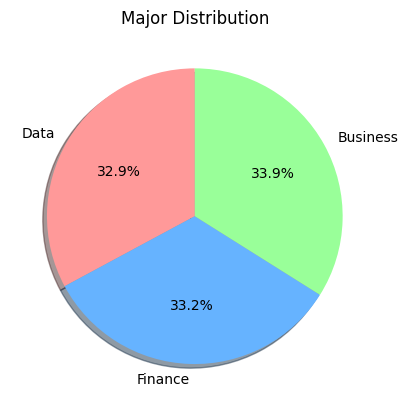

In [8]:
# Plot pie chart
plt.pie(num_students, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        shadow=True, 
        colors=['#ff9999','#66b3ff','#99ff99']
        )
plt.title('Major Distribution')
plt.show()

- Average subject scores
- Average attendance and project scores

In [9]:
uni_df.columns

Index(['first_name', 'last_name', 'class_name', 'term', 'math', 'english',
       'science', 'history', 'attendance', 'project_score', 'passed',
       'income_student', 'cohort', 'track'],
      dtype='object')

In [10]:
track_summary = uni_df.groupby("track", as_index=False).agg({
    "math": "mean",
    "english": "mean",
    "science": "mean",
    "history": "mean",
    "attendance": "mean",
    "project_score": "mean",
})

print(track_summary)


     track       math    english    science    history  attendance  \
0       BM  64.147368  63.868421  65.036842  64.194737   79.326316   
1     Data  72.032609  71.548913  72.543478  72.690217   84.173370   
2  Finance  62.032258  64.741935  65.967742  63.279570   80.006452   

   project_score  
0      71.273684  
1      72.527174  
2      69.155914  


- Pass rates based on the designated "Passed (Y/N)" column

In [11]:
passed = uni_df["passed"].value_counts()[1]
failed = uni_df["passed"].value_counts()[0]
pf_ratio = [passed, failed]
labels = ["Pass", "Fail"]

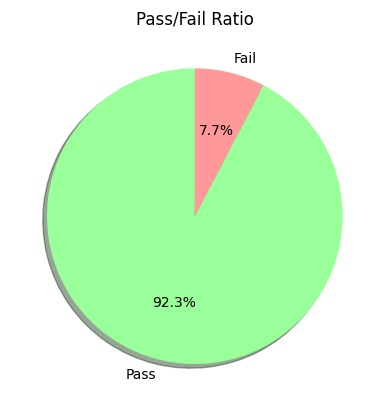

There are 92.32% students who passed and 7.68% students who failed.


In [12]:
# Plot pie chart
plt.pie(pf_ratio,
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        shadow=True, 
        colors=['#99ff99','#ff9999']
        )
plt.title('Pass/Fail Ratio')
plt.show()
print(f"There are {round(passed/(failed+passed)*100, 2)}% students who passed and {round(failed/(failed+passed)*100, 2)}% students who failed.")

# 3. Cross-Track Comparative Analysis

- Distributions of History grades for each track

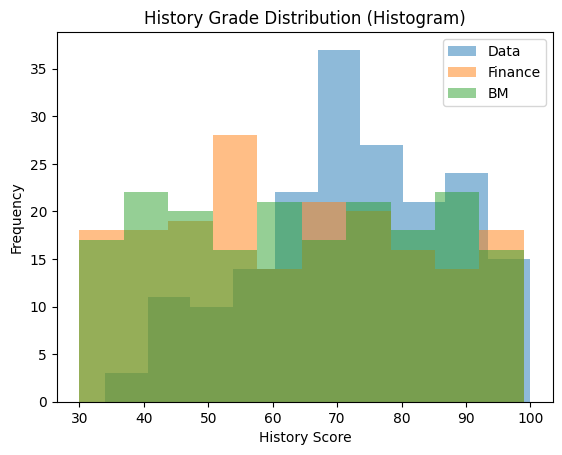

In [13]:
plt.figure()

tracks = [data_df, fin_df, bm_df]
labels = ["Data", "Finance", "BM"]

for track, label in zip(tracks, labels):
    plt.hist(track["history"], bins=10, alpha=0.5, label=label)

plt.legend()
plt.title("History Grade Distribution (Histogram)")
plt.xlabel("History Score")
plt.ylabel("Frequency")
plt.show()

/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/544618026.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


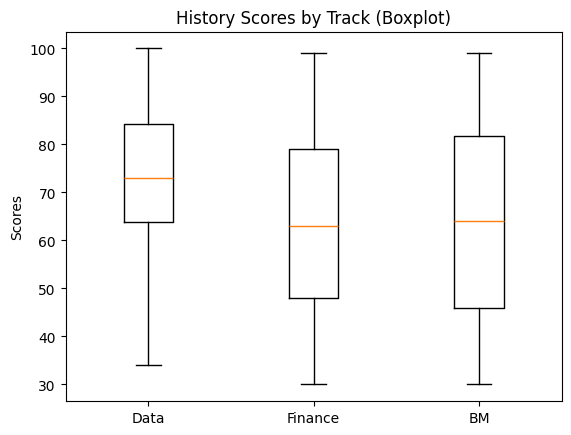

In [14]:
plt.figure()

plt.boxplot(
    [data_df["history"], fin_df["history"], bm_df["history"]],
    labels=["Data", "Finance", "BM"]
)

plt.title("History Scores by Track (Boxplot)")
plt.ylabel("Scores")
plt.show()


- Comparing average Mathematics scores between tracks

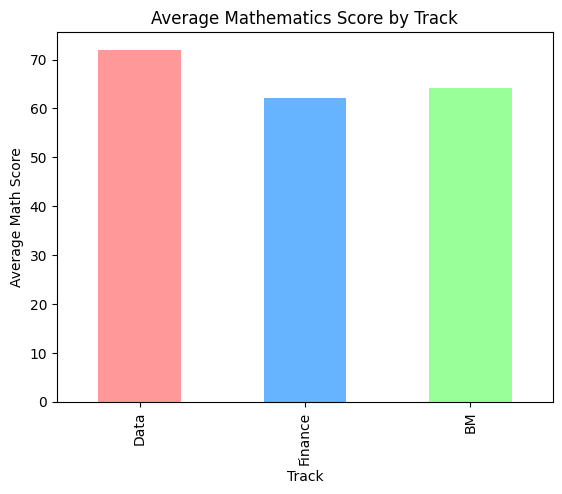

In [15]:
temp = pd.DataFrame({
    "Track": ["Data"] * len(data_df) +
             ["Finance"] * len(fin_df) +
             ["BM"] * len(bm_df),
    "Math": pd.concat([data_df["math"], fin_df["math"], bm_df["math"]], axis=0)
})

# Group, then reorder the index
avg_math = (
    temp.groupby("Track")["Math"]
        .mean()
        .reindex(["Data", "Finance", "BM"])   # <-- force the order
)

plt.figure()
avg_math.plot(kind="bar", color=["#ff9999", "#66b3ff", "#99ff99"])
plt.title("Average Mathematics Score by Track")
plt.ylabel("Average Math Score")
plt.show()


- Analyze correlations between attendance and project scores per track

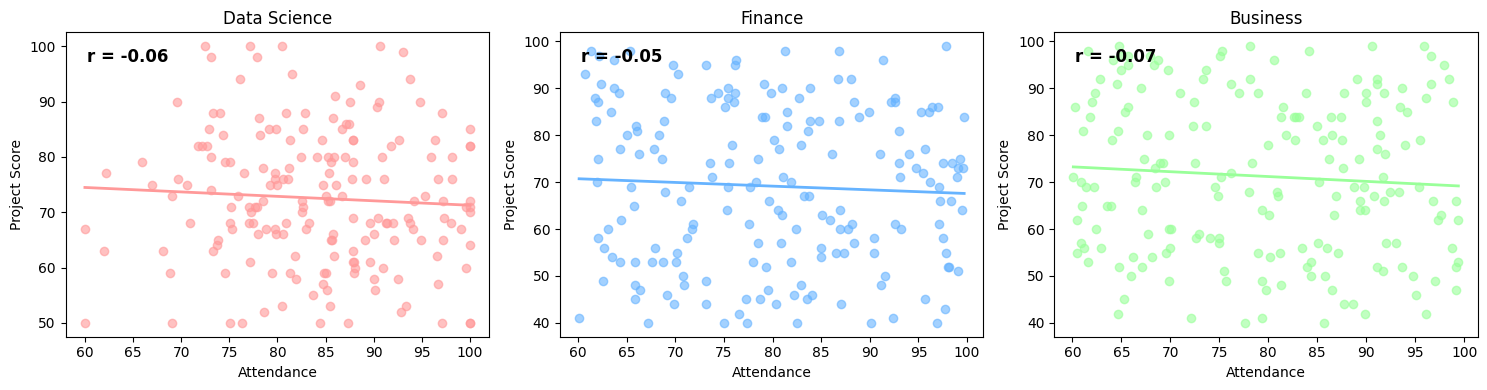

In [16]:
tracks = {
    "Data Science": data_df,
    "Finance": fin_df,
    "Business": bm_df
}

colors = {
    "Data Science": "#ff9999",
    "Finance": "#66b3ff",
    "Business": "#99ff99"
}

plt.figure(figsize=(15, 4))

for i, (name, df) in enumerate(tracks.items(), 1):

    plt.subplot(1, 3, i)
    
    # Scatter
    plt.scatter(df["attendance"], df["project_score"],
                alpha=0.6, color=colors[name])
    
    # Regression line
    m, b = np.polyfit(df["attendance"], df["project_score"], 1)
    x = np.linspace(df["attendance"].min(), df["attendance"].max(), 100)
    plt.plot(x, m*x + b, color=colors[name], linewidth=2)
    
    # Correlation
    r = df[["attendance", "project_score"]].corr().iloc[0, 1]
    
    # Display correlation on the subplot
    plt.text(
        0.05, 0.95,
        f"r = {r:.2f}",
        transform=plt.gca().transAxes,
        fontsize=12,
        fontweight="bold",
        color="black",
        verticalalignment="top"
    )
    
    plt.title(name)
    plt.xlabel("Attendance")
    plt.ylabel("Project Score")

plt.tight_layout()
plt.show()


# 4. Cohort-Level Analysis

- Calculate average grades and pass rates segmented by cohort


In [17]:
cohort_summary = uni_df.groupby("cohort").agg(
    avg_math=("math", "mean"),
    avg_english=("english", "mean"),
    avg_science=("science", "mean"),
    avg_history=("history", "mean"),
    avg_attendance=("attendance", "mean"),
    avg_project=("project_score", "mean"),
    pass_rate=("passed", "mean"),   # passed already converted to 0/1
    count=("cohort", "size")
).reset_index()

print("\nCohort-Level Summary:")
print(cohort_summary)



Cohort-Level Summary:
  cohort   avg_math  avg_english  avg_science  avg_history  avg_attendance  \
0  25-26  66.278689    67.475410    68.868852    67.420765       81.503825   
1  26-27  66.633333    65.244444    66.694444    64.477778       79.957222   
2  27-28  65.263959    67.258883    67.852792    68.010152       81.896447   

   avg_project  pass_rate  count  
0    71.437158   0.934426    183  
1    70.650000   0.905556    180  
2    70.862944   0.928934    197  


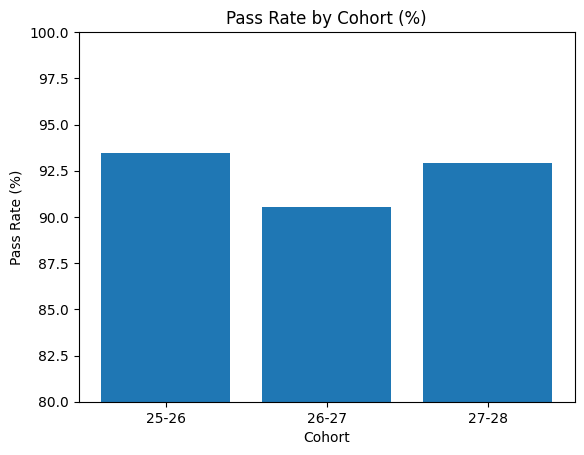

In [18]:
plt.figure()
plt.bar(cohort_summary["cohort"], cohort_summary["pass_rate"] * 100)
plt.title("Pass Rate by Cohort (%)")
plt.xlabel("Cohort")
plt.ylabel("Pass Rate (%)")
plt.ylim(80, 100)
plt.xticks(rotation=0)
plt.show()


- Compare academic performance of income-supported students (IncomeStudent = True)
against others

In [19]:
income_summary = uni_df.groupby("income_student").agg(
    avg_math=("math", "mean"),
    avg_english=("english", "mean"),
    avg_science=("science", "mean"),
    avg_history=("history", "mean"),
    avg_attendance=("attendance", "mean"),
    avg_score=("project_score", "mean"),
    pass_rate=("passed", "mean"),
    count=("income_student", "size")
).reset_index()

# Map 1/0 → labels
income_summary["Group"] = income_summary["income_student"].map({
    1: "Income Supported",
    0: "Not Supported"
})

print("\nIncome Student Performance Comparison:")
print(income_summary)




Income Student Performance Comparison:
   income_student   avg_math  avg_english  avg_science  avg_history  \
0               0  67.106383    67.100304    68.416413    67.106383   
1               1  64.510823    66.086580    66.952381    66.077922   

   avg_attendance  avg_score  pass_rate  count             Group  
0       81.715805  70.671733   0.933131    329     Not Supported  
1       80.331602  71.424242   0.909091    231  Income Supported  


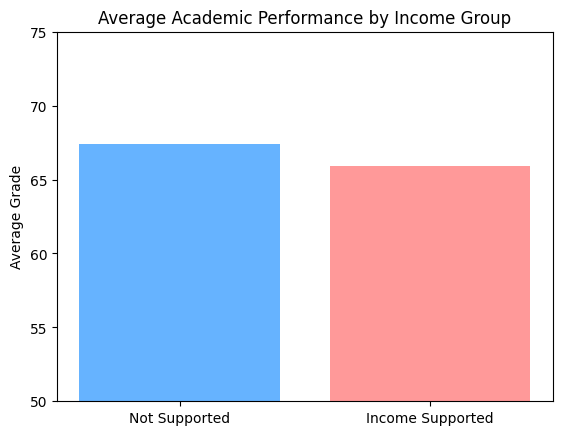

In [20]:
avg_academic = income_summary[[
    "avg_math", "avg_english", "avg_science", "avg_history"
]].mean(axis=1)

plt.figure()
plt.bar(income_summary["Group"], avg_academic, color=["#66b3ff", "#ff9999"])
plt.title("Average Academic Performance by Income Group")
plt.ylabel("Average Grade")
plt.ylim(50, 75)
plt.show()


# 5. Final Report Generation

Export a summary report as a CSV or Excel file encompassing all computed statistics
Optionally generate charts and plots using matplotlib or seaborn libraries for visual
interpretation

In [21]:
# Export each cleaned dataframe to CSV
data_df.to_csv("data_df_cleaned.csv", index=False)
fin_df.to_csv("fin_df_cleaned.csv", index=False)
bm_df.to_csv("bm_df_cleaned.csv", index=False)
uni_df.to_csv("uni_df_cleaned.csv", index=False)

print("CSV files exported successfully!")


CSV files exported successfully!


# Bonus Project Enhancements

2. Dashboard-style Excel output using xlsxwriter with enhanced formatting

In [22]:
! pip install xlsxwriter

In [23]:
# Track-level summary
track_summary = (
    uni_df
    .groupby("track")
    .agg({
        "math": "mean",
        "english": "mean",
        "science": "mean",
        "history": "mean",
        "attendance": "mean",
        "project_score": "mean"
    })
    .reset_index()
)

# Cohort-level summary
cohort_summary = (
    uni_df
    .groupby("cohort")
    .agg({
        "math": "mean",
        "english": "mean",
        "science": "mean",
        "history": "mean",
        "attendance": "mean",
        "project_score": "mean"
    })
    .reset_index()
)

In [24]:

def create_dashboard_excel(track_df, cohort_df, output_file='Final_Dashboard.xlsx'):

    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        # 1. input summary sheet
        track_df.to_excel(writer, sheet_name='track_Summary', index=False)
        cohort_df.to_excel(writer, sheet_name='Cohort_Summary', index=False)

        # 2. workbook / worksheet
        workbook = writer.book
        worksheet_track = writer.sheets['track_Summary']
        worksheet_cohort = writer.sheets['Cohort_Summary']

        # 3. setting the format
        header_fmt = workbook.add_format({
            'bold': True,
            'bg_color': '#D7E4BC',
            'border': 1
        })
        num_fmt = workbook.add_format({'num_format': '0.00'})

        worksheet_track.set_column('B:G', 12, num_fmt)
        worksheet_track.set_row(0, None, header_fmt)

        worksheet_cohort.set_column('B:G', 12, num_fmt)
        worksheet_cohort.set_row(0, None, header_fmt)

        # =========================================================
        # 4. track_Summary plot
        # =========================================================
        chart_track = workbook.add_chart({'type': 'column'})

        max_row_track = len(track_df) + 1 


        # Math
        chart_track.add_series({
            'name':       ['track_Summary', 0, 1],
            'categories': ['track_Summary', 1, 0, max_row_track - 1, 0],
            'values':     ['track_Summary', 1, 1, max_row_track - 1, 1],
        })

        # English
        chart_track.add_series({
            'name':       ['track_Summary', 0, 2],
            'categories': ['track_Summary', 1, 0, max_row_track - 1, 0],
            'values':     ['track_Summary', 1, 2, max_row_track - 1, 2],
        })

        # Science
        chart_track.add_series({
            'name':       ['track_Summary', 0, 3],
            'categories': ['track_Summary', 1, 0, max_row_track - 1, 0],
            'values':     ['track_Summary', 1, 3, max_row_track - 1, 3],
        })

        # History
        chart_track.add_series({
            'name':       ['track_Summary', 0, 4],
            'categories': ['track_Summary', 1, 0, max_row_track - 1, 0],
            'values':     ['track_Summary', 1, 4, max_row_track - 1, 4],
        })

        chart_track.set_title({'name': 'Average Scores by track'})
        chart_track.set_x_axis({'name': 'track'})
        chart_track.set_y_axis({'name': 'Score'})

        worksheet_track.insert_chart('I2', chart_track)

        # =========================================================
        # 5. Cohort_Summary plot
        # =========================================================
        chart_cohort = workbook.add_chart({'type': 'column'})

        max_row_cohort = len(cohort_df) + 1  

        # Math
        chart_cohort.add_series({
            'name':       ['Cohort_Summary', 0, 1],
            'categories': ['Cohort_Summary', 1, 0, max_row_cohort - 1, 0],
            'values':     ['Cohort_Summary', 1, 1, max_row_cohort - 1, 1],
        })

        # English
        chart_cohort.add_series({
            'name':       ['Cohort_Summary', 0, 2],
            'categories': ['Cohort_Summary', 1, 0, max_row_cohort - 1, 0],
            'values':     ['Cohort_Summary', 1, 2, max_row_cohort - 1, 2],
        })

        # Science
        chart_cohort.add_series({
            'name':       ['Cohort_Summary', 0, 3],
            'categories': ['Cohort_Summary', 1, 0, max_row_cohort - 1, 0],
            'values':     ['Cohort_Summary', 1, 3, max_row_cohort - 1, 3],
        })

        # History
        chart_cohort.add_series({
            'name':       ['Cohort_Summary', 0, 4],
            'categories': ['Cohort_Summary', 1, 0, max_row_cohort - 1, 0],
            'values':     ['Cohort_Summary', 1, 4, max_row_cohort - 1, 4],
        })

        chart_cohort.set_title({'name': 'Average Scores by Cohort'})
        chart_cohort.set_x_axis({'name': 'Cohort'})
        chart_cohort.set_y_axis({'name': 'Score'})
        
        worksheet_cohort.insert_chart('I2', chart_cohort)

    print(f"Dashboard generated: {output_file}")


In [25]:
create_dashboard_excel(track_summary, cohort_summary, output_file='Final_Dashboard.xlsx')

Dashboard generated: Final_Dashboard.xlsx


3. Automated performance alerts flagging low-performing tracks or cohorts

===== Performance Alert Table =====


,track,cohort,math,english,science,history,AvgScore,LowPerformance,Alert
0,BM,25-26,63.049180,64.213115,67.196721,65.868852,65.081967,False,OK
1,BM,26-27,65.213115,63.983607,60.409836,62.000000,62.901639,False,OK
2,BM,27-28,64.176471,63.455882,67.250000,64.661765,64.886029,False,OK
3,Data,25-26,71.676923,71.353846,72.092308,72.169231,71.823077,False,OK
4,Data,26-27,72.290909,72.054545,72.363636,71.218182,71.981818,False,OK
5,Data,27-28,72.171875,71.312500,73.156250,74.484375,72.781250,False,OK
6,Finance,25-26,63.578947,66.543860,66.982456,63.666667,65.192982,False,OK
7,Finance,26-27,63.125000,60.593750,67.812500,61.046875,63.144531,False,OK
8,Finance,27-28,59.600000,67.246154,63.261538,65.138462,63.811538,False,OK


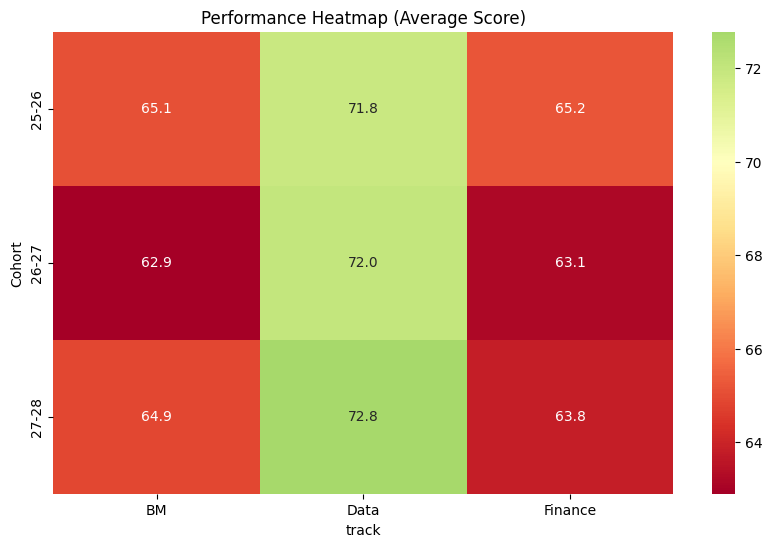


===== Automated Text Alert Report =====

No alerts. All tracks and cohorts meet performance standards.


In [26]:
# ============================================================
# Includes:
# A. Threshold-based Alert Table
# B. Heatmap Visualization
# C. Text Alert Report
# ============================================================
import seaborn as sns
df_alert = uni_df.copy()

subject_cols = ["math", "english", "science", "history"]

# ---------------------------------------------
# STEP A: alert threshold settings
# ---------------------------------------------
alert_threshold = 60  # we can change the threshold here

agg = (
    df_alert
    .groupby(["track", "cohort"])[subject_cols]
    .mean()
    .reset_index()
)

agg["AvgScore"] = agg[subject_cols].mean(axis=1)
agg["LowPerformance"] = agg["AvgScore"] < alert_threshold
agg["Alert"] = agg["LowPerformance"].apply(lambda x: "⚠ LOW PERFORMANCE" if x else "OK")

print("===== Performance Alert Table =====")
display(agg.sort_values(["track", "cohort"]))


# ---------------------------------------------
# STEP B: performance heating map
# ---------------------------------------------
plt.figure(figsize=(10, 6))
pivot = agg.pivot(index="cohort", columns="track", values="AvgScore")
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="RdYlGn", center=70)
plt.title("Performance Heatmap (Average Score)")
plt.ylabel("Cohort")
plt.xlabel("track")
plt.show()


# ---------------------------------------------
# STEP C: text alarm
# ---------------------------------------------
alerts = agg[agg["LowPerformance"] == True]

print("\n===== Automated Text Alert Report =====\n")

if len(alerts) == 0:
    print("No alerts. All tracks and cohorts meet performance standards.")
else:
    for _, row in alerts.iterrows():
        print(
            f"• {row['track']} track in cohort {row['cohort']} "
            f"is low-performing (Average Score = {row['AvgScore']:.1f})"
        )


4. Trend analysis of performance metrics over multiple terms or academic years, if applicable (to do that, you’ll need to generate other years data)

In [27]:
base_df = uni_df.reset_index().copy()


existing_cohorts = set(base_df["cohort"].astype(str).unique())
candidate_new = ["23-24", "24-25", "25-26"]  
new_cohorts = [c for c in candidate_new if c not in existing_cohorts]

print("Existing cohorts:", existing_cohorts)
print("New cohorts to generate:", new_cohorts)

track_sizes = base_df.groupby("track")["student_id"].count().to_dict()
print("track sizes:", track_sizes)

synthetic_rows = []
max_id = base_df["student_id"].max()  

for cohort in new_cohorts:
    for track, size in track_sizes.items():
        track_df = base_df[base_df["track"] == track]
        sampled = track_df.sample(n=size, replace=True).copy()
        sampled["student_id"] = range(max_id + 1, max_id + 1 + size)
        max_id += size
        sampled["cohort"] = cohort

       
        for col in ["math", "english", "science", "history"]:
            sampled[col] = (
                sampled[col].astype(float)
                + np.random.normal(loc=0, scale=5, size=len(sampled))  
            ).clip(0, 100).round().astype(int)  

        synthetic_rows.append(sampled)

# combine
synthetic_df = pd.concat(synthetic_rows, ignore_index=True)
uni_df_all = pd.concat([base_df, synthetic_df], ignore_index=True)
uni_df_all = uni_df_all.set_index("student_id")
print("Cohort counts in extended dataset:")
print(uni_df_all["cohort"].value_counts().sort_index())


Existing cohorts: {'27-28', '25-26', '26-27'}
New cohorts to generate: ['23-24', '24-25']
track sizes: {'BM': 190, 'Data': 184, 'Finance': 186}
Cohort counts in extended dataset:
cohort
23-24    560
24-25    560
25-26    183
26-27    180
27-28    197
Name: count, dtype: int64


/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/2868929597.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cohort", "track"])[subj]


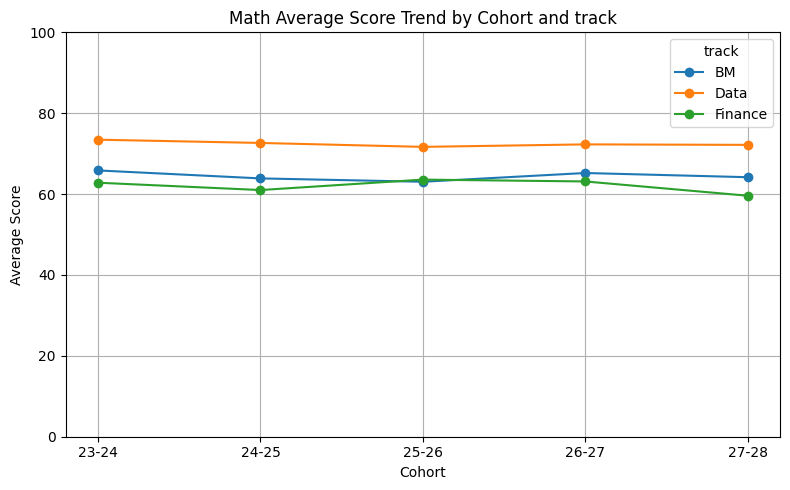

/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/2868929597.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cohort", "track"])[subj]


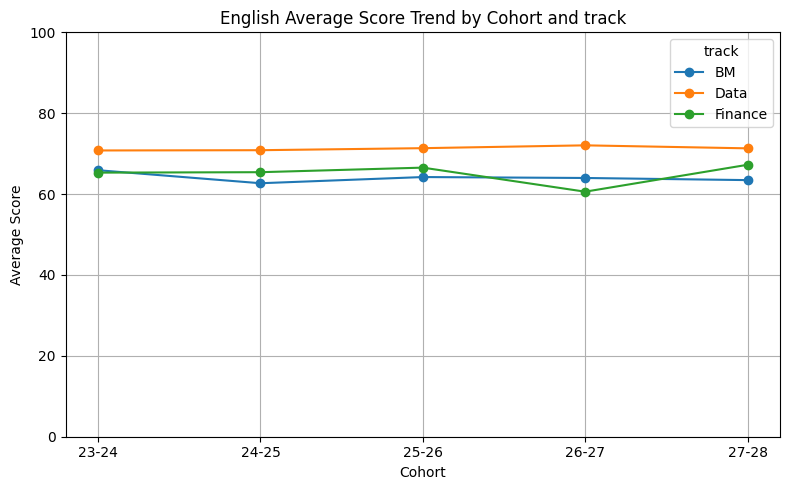

/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/2868929597.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cohort", "track"])[subj]


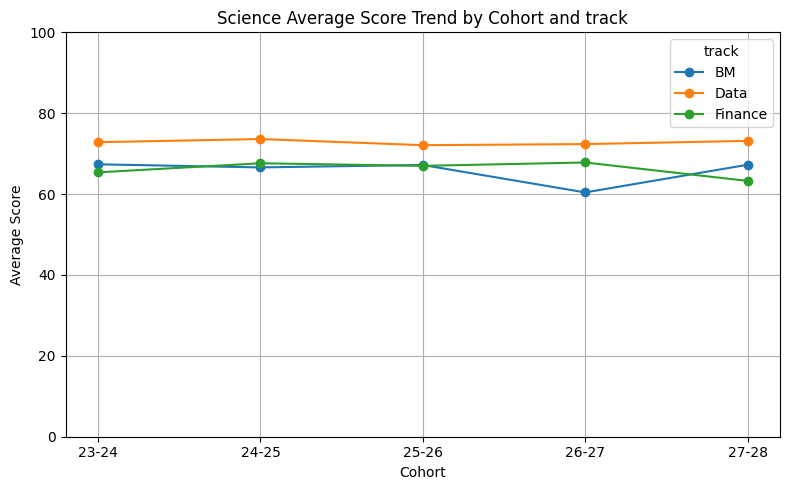

/var/folders/h9/pq98t39d673fnx9b2jj8k3pm0000gn/T/ipykernel_26080/2868929597.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cohort", "track"])[subj]


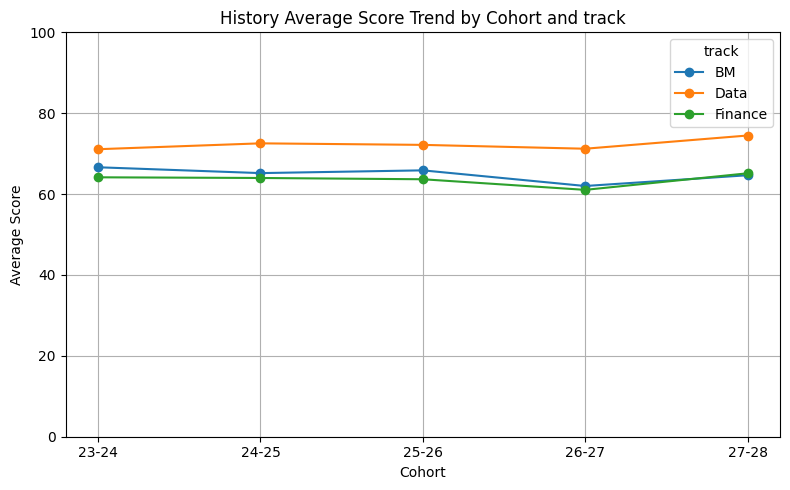

In [28]:

uni_df_all = uni_df_all.copy()
uni_df_all["cohort"] = uni_df_all["cohort"].astype(str)

cohort_order = sorted(
    uni_df_all["cohort"].unique(),
    key=lambda x: int(x.split("-")[0])
)
uni_df_all["cohort"] = pd.Categorical(
    uni_df_all["cohort"],
    categories=cohort_order,
    ordered=True
)

subjects = ["math", "english", "science", "history"]

for subj in subjects:
    plt.figure(figsize=(8, 5))

    mean_scores = (
        uni_df_all
        .groupby(["cohort", "track"])[subj]
        .mean()
        .reset_index()
    )

    for track in mean_scores["track"].unique():
        track_data = mean_scores[mean_scores["track"] == track]
        plt.plot(
            track_data["cohort"],
            track_data[subj],
            marker="o",
            label=track
        )

    plt.title(f"{subj.capitalize()} Average Score Trend by Cohort and track")
    plt.xlabel("Cohort")
    plt.ylabel("Average Score")
    plt.ylim(0, 100)
    plt.legend(title="track")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
